In [1]:
#inporting all dependencies
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

In [2]:
#Loading CIFAR10 dataset and creating the batches from it
traindata=torchvision.datasets.CIFAR10(root="data",train=True,download=True,transform=transforms.ToTensor())
testdata=torchvision.datasets.CIFAR10(root="data",train=False,download=True,transform=transforms.ToTensor())
trainloader=torch.utils.data.DataLoader(traindata,batch_size=100,shuffle=True)
testloader=torch.utils.data.DataLoader(testdata,batch_size=100,shuffle=False)

100%|██████████| 170498071/170498071 [02:41<00:00, 1056495.92it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
#Network for the model
class cnn(nn.Module):
    def __init__(self):
        super(cnn,self).__init__()
        self.conv1=nn.Conv2d(3,16,3,1,padding=1)
        self.conv2=nn.Conv2d(16,32,3,1,padding=1)
        self.conv3=nn.Conv2d(32,64,3,1,padding=1)
        self.conv4=nn.Conv2d(64,128,3,1,padding=1)
        self.conv5=nn.Conv2d(128,256,3,1,padding=1)
        self.b1=nn.BatchNorm2d(16)
        self.b2=nn.BatchNorm2d(64)  #batch normalization
        self.b3=nn.BatchNorm2d(256)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

        self.dropout=nn.Dropout(0.1)
        self.fc1=nn.Linear(256,128)
        self.fc2=nn.Linear(128,64)  #fully connected layer
        self.out=nn.Linear(64,10)


    def forward(self,x):
        x=self.pool(f.relu(self.b1(self.conv1(x))))
        x=self.pool(f.relu(self.conv2(x)))
        x=self.pool(f.relu(self.b2(self.conv3(x))))
        x=self.pool(f.relu(self.conv4(x)))
        x=self.pool(f.relu(self.b3(self.conv5(x))))
        x=x.view(-1,256)         #falttening
        x = self.dropout(x)
        x=self.dropout(f.relu(self.fc1(x)))
        x=self.dropout(f.relu(self.fc2(x)))
        x=self.out(x)
        return x

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=cnn().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [7]:
#training loop
for epoch in range(50):
  model.train()
  costs=[]
  acuracies=[]
  correct=0
  total=0
  #iterating over batches
  for batch,(data,target) in enumerate(trainloader):
    data,target=data.to(device),target.to(device)
    optimizer.zero_grad()
    output=model(data)
    pred=output.argmax(dim=1,keepdim=True)
    correct+=pred.eq(target.view_as(pred)).sum().item()
    total+=target.size(0)
    acuracies.append((correct/total)*100)
    loss=criterion(output,target)
    loss.backward()
    optimizer.step()
    costs.append(loss.cpu().detach().numpy())
  if(epoch%10==0):
    print(f"the loss after the {epoch} epoch is:{loss},accuracy:{(correct/total)*100}")

the loss after the 0 epoch is:1.2757807970046997,accuracy:49.084
the loss after the 10 epoch is:0.37767815589904785,accuracy:86.586
the loss after the 20 epoch is:0.14622904360294342,accuracy:94.596
the loss after the 30 epoch is:0.2083619087934494,accuracy:96.848
the loss after the 40 epoch is:0.05433282256126404,accuracy:97.532


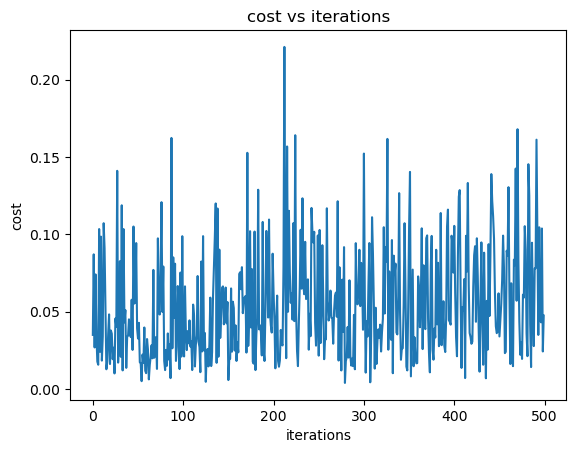

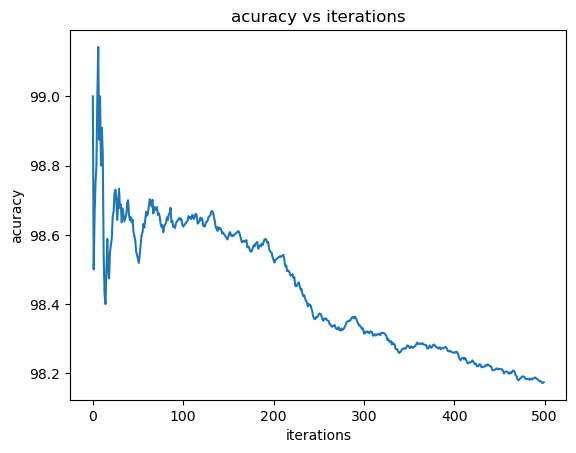

accuracy on testset:75.35


In [9]:
import matplotlib.pyplot as plt
#ploting the cost vs iterations
plt.plot(costs)
plt.xlabel("iterations")
plt.ylabel("cost")
plt.title("cost vs iterations")
plt.show()

#ploting the acuracy vs iterations
plt.plot(acuracies)
plt.xlabel("iterations")
plt.ylabel("acuracy")
plt.title("acuracy vs iterations")
plt.show()
#function for evaluating model on the testset
def test():
  model.eval()
  correct=0
  with torch.no_grad():
    for data,target in testloader:
      data,target=data.to(device),target.to(device)
      output=model(data)
      pred=output.argmax(dim=1,keepdim=True)
      correct+=pred.eq(target.view_as(pred)).sum().item()
  print(f"accuracy on testset:{(correct/len(testloader.dataset))*100}")

test()